## **Housing Price Prediction (Beijing 2011-2017)**

**Description:** Utilizes various ML models to predict housing price in Beijing using datasets 2011-2017.\
**Data:** public dataset available on Kaggle.com

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
color_pal = sns.color_palette()
# pd.set_option('max_columns', 200)

# RFE & XGBoost packages
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('../new.csv', encoding='cp1252')

### (i) Data Inspection

In [5]:
df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [6]:
df.shape

(318851, 26)

In [7]:
df.rename(
    columns={"livingRoom": "bedRoom", "drawingRoom": "livingRoom"},
    inplace=True,
)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  bedRoom              318851 non-null  object 
 12  livingRoom           318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

In [9]:
df.describe()

,Lng,Lat,Cid,DOM,followers,totalPrice,price,square,kitchen,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
count,318851.000000,318851.000000,3.188510e+05,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,316830.000000,318851.000000,318851.000000,3.188510e+05,318819.000000,318819.000000,318819.000000,318851.000000,318388.000000
mean,116.418459,39.949591,1.129113e+12,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,3.009790,2.606330,4.451026,6.316486e+01,0.577055,0.645601,0.601112,6.763564,63682.446305
std,0.112054,0.091983,2.363447e+12,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,1.269857,1.311739,1.901753,2.506851e+04,0.494028,0.478331,0.489670,2.812616,22329.215447
min,116.072514,39.627030,1.111027e+12,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,0.048000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,116.344985,39.893200,1.111027e+12,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,1.000000,1.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46339.000000
50%,116.416780,39.934527,1.111027e+12,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,4.000000,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59015.000000
75%,116.477581,40.003018,1.111027e+12,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,4.000000,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75950.000000
max,116.732378,40.252758,1.114620e+15,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,4.000000,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000


In [10]:
df["district"].value_counts()

7     107244
6      38634
8      38200
10     31293
2      29338
1      17086
4      15313
11     13974
9      11371
13      9202
5       2955
3       2537
12      1704
Name: district, dtype: int64

In [11]:
df['price'].describe()

count    318851.000000
mean      43530.436379
std       21709.024204
min           1.000000
25%       28050.000000
50%       38737.000000
75%       53819.500000
max      156250.000000
Name: price, dtype: float64

### (ii) Data Cleaning

In [12]:
# Sample a random subset of rows
df = df.sample(n=20000, random_state=42)  # adjust n to the number of samples you want

# cast trade time to datetime format
df['tradeTime'] = pd.to_datetime(df['tradeTime'])

# fix time frame and drop redundant values
df = df.loc[df['tradeTime']>='2011-01-01']

# check shape
df[df['price'] > 10].shape

(19970, 26)

In [13]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'bedRoom', 'livingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage'],
      dtype='object')

In [14]:
# Checking Null values
df.isnull().sum()*100/df.shape[0]

url                     0.000000
id                      0.000000
Lng                     0.000000
Lat                     0.000000
Cid                     0.000000
tradeTime               0.000000
DOM                    50.240240
followers               0.000000
totalPrice              0.000000
price                   0.000000
square                  0.000000
bedRoom                 0.000000
livingRoom              0.000000
kitchen                 0.000000
bathRoom                0.000000
floor                   0.000000
buildingType            0.585586
constructionTime        0.000000
renovationCondition     0.000000
buildingStructure       0.000000
ladderRatio             0.000000
elevator                0.020020
fiveYearsProperty       0.020020
subway                  0.020020
district                0.000000
communityAverage        0.115115
dtype: float64

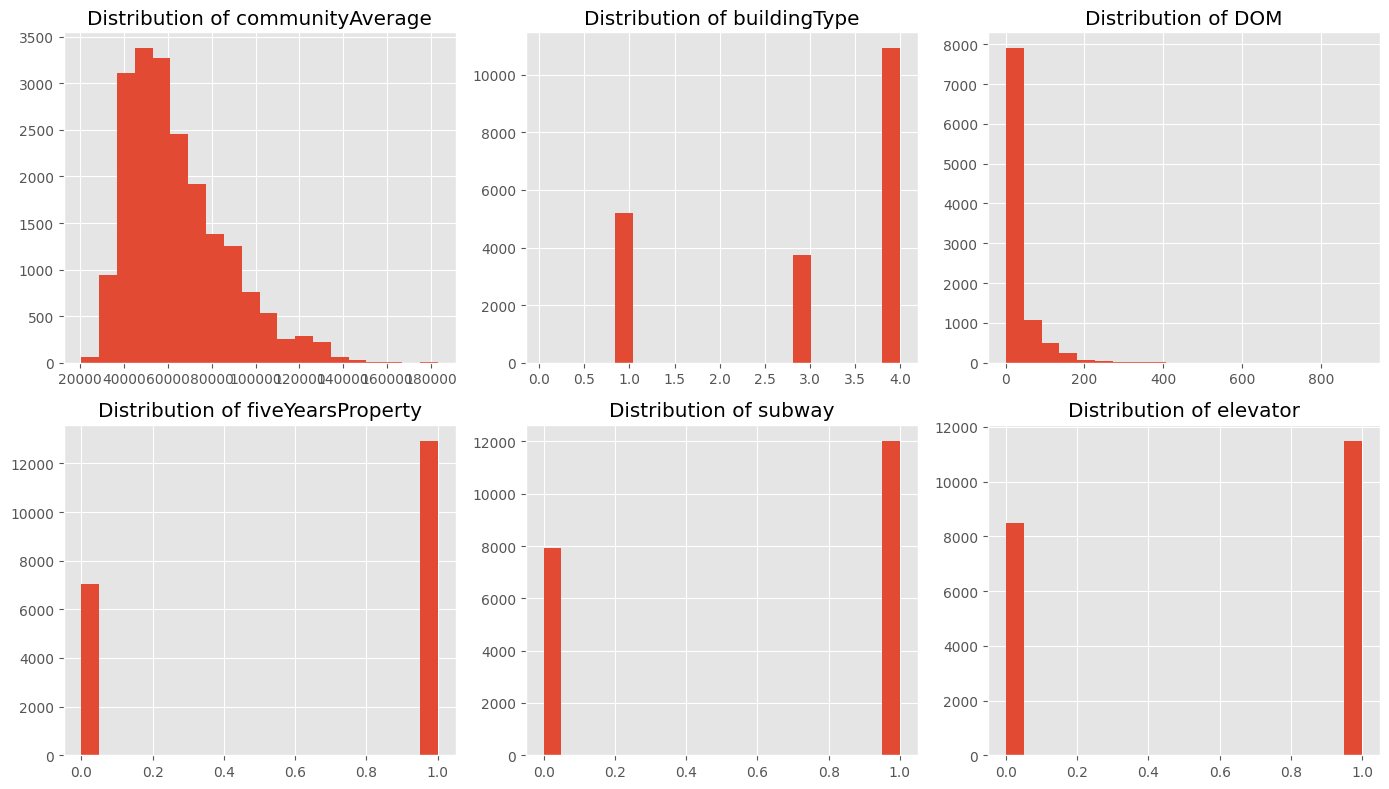

In [15]:
features = ['communityAverage', 'buildingType', 'DOM', 'fiveYearsProperty', 'subway', 'elevator']

plt.figure(figsize=(14, 8))

# Create a histogram for each feature
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)  # Adjust the index for a 2x3 layout
    df[feature].hist(bins=20)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

plt.show()

In [16]:
# deal with na

# Dummy Variables: fiveYearsProperty, subway, elevator
for col in ['fiveYearsProperty','elevator','subway']:
    df[col].fillna(df[col].median(), inplace=True)
# Discrete Variable: buildingType, DOM
for col in ['DOM','buildingType']:
    df[col].fillna(df[col].median(), inplace=True)
# Continuous Variable: communityAverage
for col in ['communityAverage']:
    df[col].fillna(df[col].mean(), inplace=True)   


In [17]:
df = df.drop(['url', 'Cid', 'id'], axis=1)
print(df.shape)

(19980, 23)


In [18]:
# deal with wierd symbols in floor
df['floor_numeric'] = df['floor'].str.extract(r'(\d+)').astype(float)
df['floor_numeric'] = df['floor_numeric'].fillna(-1).astype(int)
df = df[df['floor_numeric'] >= 0]
df = df.drop(['floor'], axis=1)

In [19]:
df['floor_numeric']

97134     18
36746     17
277079     4
66062      8
264397     6
          ..
228657    32
95545      6
175081    11
52143      6
260545    27
Name: floor_numeric, Length: 19976, dtype: int64

In [20]:
# Define a function to replace non-numeric values with NaN
def replace_non_numeric_with_nan(value):
    try:
        return float(value)
    except ValueError:
        return np.nan
df['constructionTime'] = df['constructionTime'].apply(replace_non_numeric_with_nan)

df=df.dropna(subset=['constructionTime'])
print(df.shape)


(18747, 23)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18747 entries, 97134 to 260545
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Lng                  18747 non-null  float64       
 1   Lat                  18747 non-null  float64       
 2   tradeTime            18747 non-null  datetime64[ns]
 3   DOM                  18747 non-null  float64       
 4   followers            18747 non-null  int64         
 5   totalPrice           18747 non-null  float64       
 6   price                18747 non-null  int64         
 7   square               18747 non-null  float64       
 8   bedRoom              18747 non-null  object        
 9   livingRoom           18747 non-null  object        
 10  kitchen              18747 non-null  int64         
 11  bathRoom             18747 non-null  object        
 12  buildingType         18747 non-null  float64       
 13  constructionTime     18747

In [22]:
# deal with data errors or occurences of '#NAME?' due to Chinese characters transformation errors
for col in df.columns:
    if df[col].dtype == 'object':
        # Replace '#NAME?' with NaN
        df[col] = df[col].replace('#NAME?', np.nan)

# After replacing '#NAME?' with NaN, we drop them since we have large dataset
df = df.dropna()
print(df.shape)

(18747, 23)


In [23]:
# cast string types to numbers
df['bedRoom'] = df['bedRoom'].astype(float)
df['livingRoom'] = df['livingRoom'].astype(float)
df['bathRoom'] = df['bathRoom'].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18077 entries, 97134 to 260545
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Lng                  18077 non-null  float64       
 1   Lat                  18077 non-null  float64       
 2   tradeTime            18077 non-null  datetime64[ns]
 3   DOM                  18077 non-null  float64       
 4   followers            18077 non-null  int64         
 5   totalPrice           18077 non-null  float64       
 6   price                18077 non-null  int64         
 7   square               18077 non-null  float64       
 8   bedRoom              18077 non-null  float64       
 9   livingRoom           18077 non-null  float64       
 10  kitchen              18077 non-null  int64         
 11  bathRoom             18077 non-null  float64       
 12  buildingType         18077 non-null  float64       
 13  constructionTime     18077

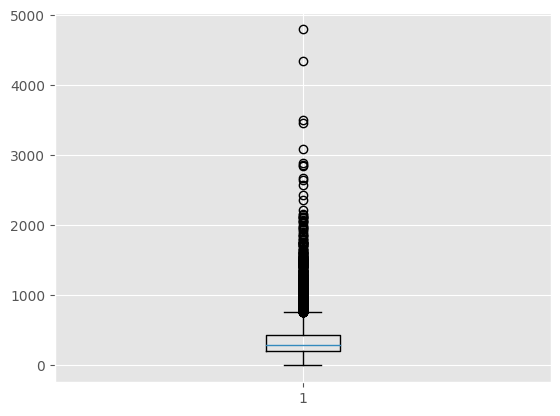

In [24]:
# deal with outliers
k = 1.8
plt.boxplot(df['totalPrice'])

Q1 = df['totalPrice'].quantile(0.25)
Q3 = df['totalPrice'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_filtered = df[(df['totalPrice'] >= Q1 - k * IQR) & (df['totalPrice'] <= Q3 + k * IQR)]
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17679 entries, 97134 to 260545
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Lng                  17679 non-null  float64       
 1   Lat                  17679 non-null  float64       
 2   tradeTime            17679 non-null  datetime64[ns]
 3   DOM                  17679 non-null  float64       
 4   followers            17679 non-null  int64         
 5   totalPrice           17679 non-null  float64       
 6   price                17679 non-null  int64         
 7   square               17679 non-null  float64       
 8   bedRoom              17679 non-null  float64       
 9   livingRoom           17679 non-null  float64       
 10  kitchen              17679 non-null  int64         
 11  bathRoom             17679 non-null  float64       
 12  buildingType         17679 non-null  float64       
 13  constructionTime     17679

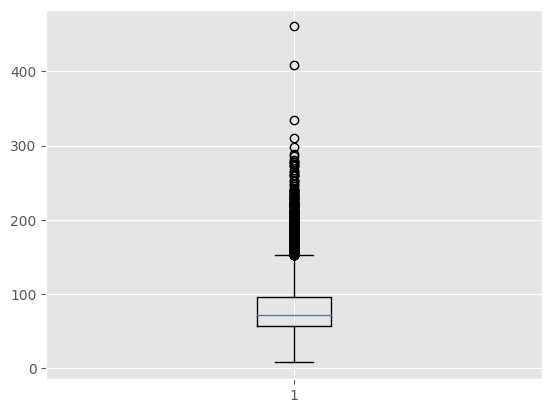

In [25]:
# deal with outliers
plt.boxplot(df_filtered['square'])

Q1 = df_filtered['square'].quantile(0.25)
Q3 = df_filtered['square'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_filtered = df_filtered[(df_filtered['square'] >= Q1 - k * IQR) &
                           (df_filtered['square'] <= Q3 + k * IQR)]
df_filtered.info()
df = df_filtered


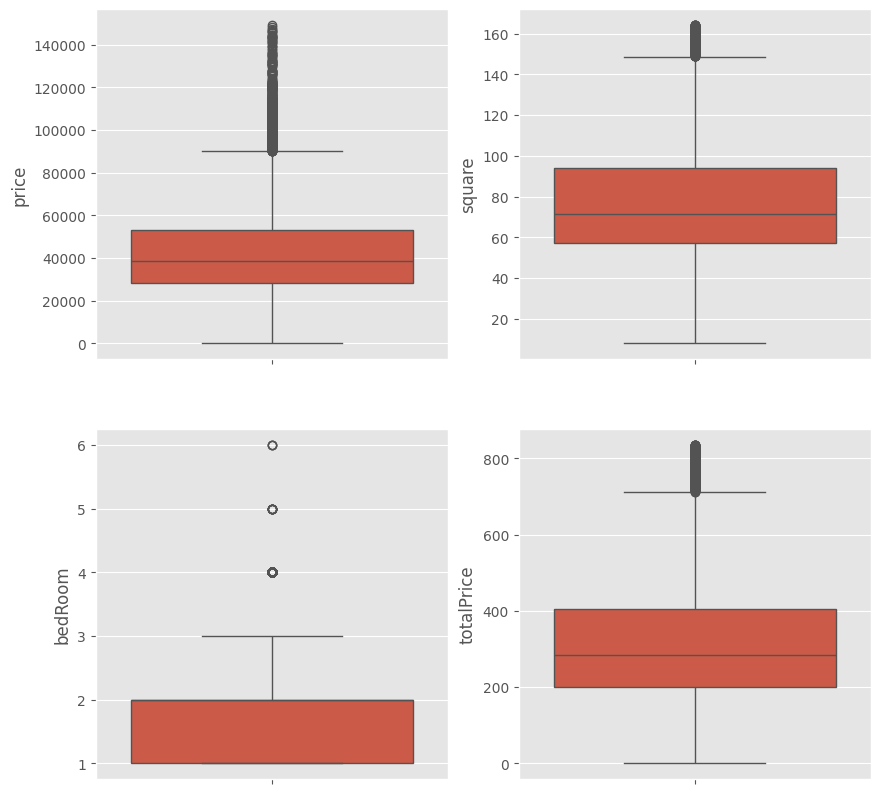

In [26]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
plt1 = sns.boxplot(df_filtered['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_filtered['square'], ax = axs[0,1])
plt3 = sns.boxplot(df_filtered['bedRoom'], ax = axs[1,0])
plt1 = sns.boxplot(df_filtered['totalPrice'], ax = axs[1,1])

In [27]:
# create a copy of cleaned data
actual_df = df.copy()

Text(0, 0.5, 'Price')

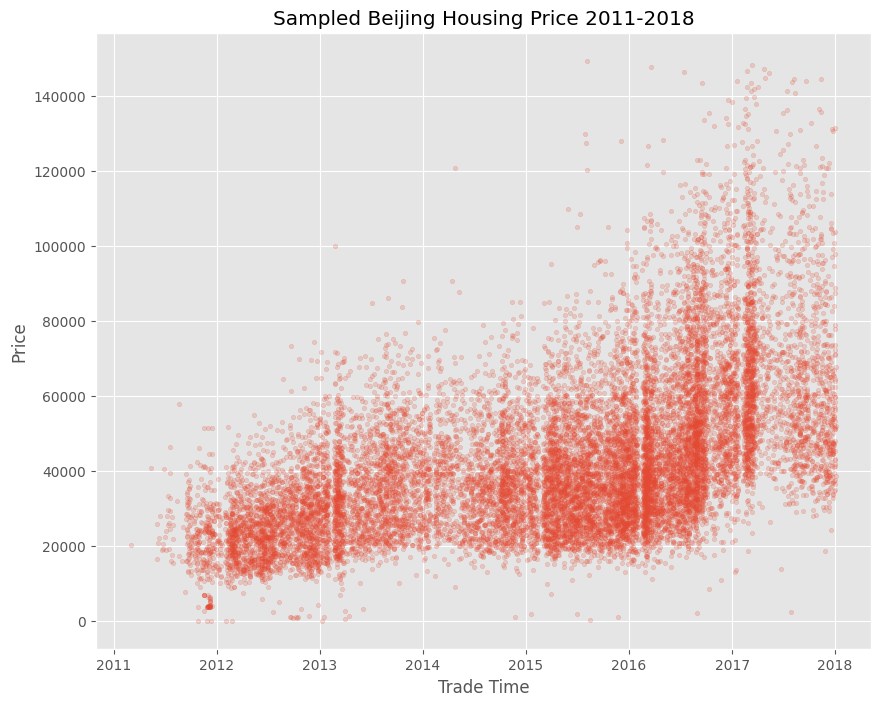

In [28]:
# plot cleaned data
plt.figure(figsize=(10, 8))
plt.scatter(df['tradeTime'], df['price'], alpha=0.2, s=10)# Reduce marker size and add transparency

# Improve the axes and labels
plt.title('Sampled Beijing Housing Price 2011-2018')
plt.xlabel('Trade Time')
plt.ylabel('Price')
# plt.yscale('log')  # Only use if appropriate for your data

### (iii) Modeling

#### Train & Test Split

In [29]:
import matplotlib.dates as mdates
def plot_df_train_test(cutoff_date, train, test):
    # Assuming df is your DataFrame and 'tradeTime' and 'price' are columns in your DataFrame
    plt.figure(figsize=(10, 8))

    # Plotting train data in blue
    plt.scatter(train['tradeTime'], train['price'], alpha=0.2, s=10, color='blue', label='Train Data')

    # Plotting test data in red
    plt.scatter(test['tradeTime'], test['price'], alpha=0.2, s=10, color='red', label='Test Data')

    # Plotting cutoff date in black dashed line
    plt.axvline(pd.to_datetime(cutoff_date, format='%Y-%M-%d'), color='black', ls='--',label='Cutoff Date')

    # Improve the axes and labels
    plt.xlabel('Trade Time')
    plt.ylabel('Price')
    # plt.yscale('log')  # Only use if appropriate for your data

    # Formatting the date axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()  # Beautify the x-labels

    plt.show()

(10444, 23) (7235, 23)


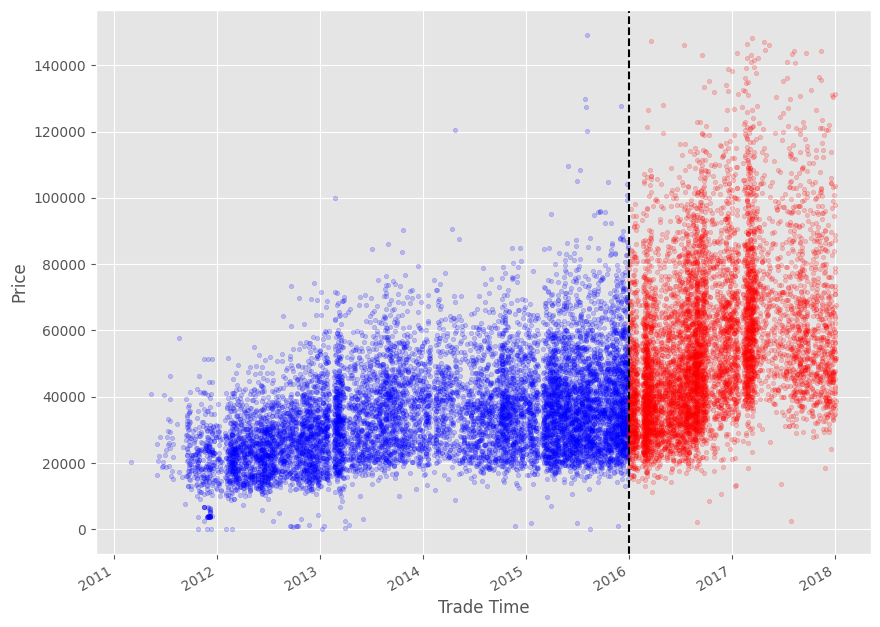

In [30]:
cutoff_date = '2016-01-01'
train = df.loc[df['tradeTime'] < cutoff_date]
test = df.loc[df['tradeTime'] >= cutoff_date]
print(train.shape, test.shape)
plot_df_train_test(cutoff_date, train, test)


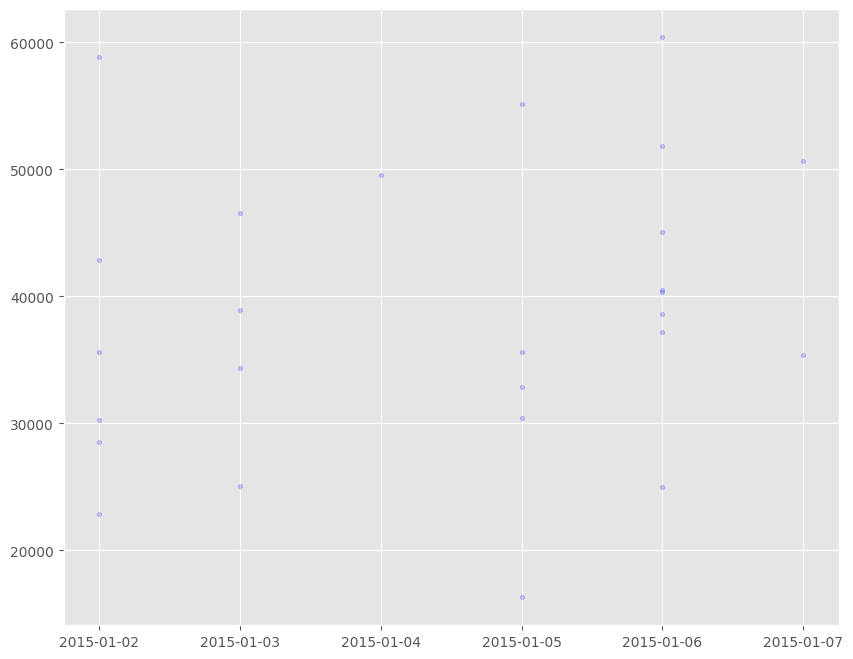

In [31]:
plt.figure(figsize=(10, 8))
half_year_df = df.loc[(df['tradeTime'] > '2015-01-01') & (df['tradeTime'] < '2015-01-08')] 
plt.scatter(half_year_df['tradeTime'], half_year_df['price'], alpha=0.2, s=10, color='blue')
plt.show()                     

In [32]:
df['floor_numeric']

97134     18
66062      8
264397     6
106895     6
235539    16
          ..
46527     20
228657    32
95545      6
52143      6
260545    27
Name: floor_numeric, Length: 17679, dtype: int64

#### Feature Engineering 

In [33]:
def create_neiborhood_cluster(df):
    # Standardize the coordinates
    coords = df[['Lng', 'Lat']]
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.2, min_samples=5)  # eps and min_samples must be tuned
    clusters = dbscan.fit_predict(coords_scaled)

    # Add the cluster label as a new feature
    df['neighborhood_cluster'] = clusters
    return df

def create_features(df):
    # building age
    df['constructionTime'] = pd.to_datetime(df['constructionTime'])
    df['buildingAge'] = df['tradeTime'].dt.year - df['constructionTime'].astype('int64')
    # transform date to numeric value
    earliest_date = df['tradeTime'].min()
    df['daysSince20110101'] = (df['tradeTime'] - earliest_date).dt.days
    # generate a number of time variables
    df['tradeQuater'] = df['tradeTime'].dt.quarter
    df['tradeMonth'] = df['tradeTime'].dt.month
    df['tradeWeek'] = df['tradeTime'].dt.week
    df['tradeDayofWeek'] = df['tradeTime'].dt.dayofweek
    df['tradeYear'] = df['tradeTime'].dt.year
    # generate ratio of square:room
    df['sqreToBedroom'] = df['square']/df['bedRoom']
    # create neibourhood clusters
    df = create_neiborhood_cluster(df)
    # create accessibility features
    df['accessibilityScore'] = df['elevator'] + df['subway']
    # district average 
    df['districtAverage'] = df.groupby('district')['communityAverage'].transform('mean')
    
    # clean up non-numeric values
    df=df.drop(['tradeTime','constructionTime'], axis=1)
    return df

df = create_features(df)

In [34]:
# print 
print(len(df.columns),'\n', df.columns)

32 
 Index(['Lng', 'Lat', 'DOM', 'followers', 'totalPrice', 'price', 'square',
       'bedRoom', 'livingRoom', 'kitchen', 'bathRoom', 'buildingType',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage',
       'floor_numeric', 'buildingAge', 'daysSince20110101', 'tradeQuater',
       'tradeMonth', 'tradeWeek', 'tradeDayofWeek', 'tradeYear',
       'sqreToBedroom', 'neighborhood_cluster', 'accessibilityScore',
       'districtAverage'],
      dtype='object')


#### Create model

In [35]:
train = create_features(train)
test = create_features(test)

FEATURES = list(df.columns)
FEATURES.remove('price')
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test= test[TARGET]

##### RFE (Recursive Feature Elimination)

In [36]:
xgb_model = xgb.XGBRegressor(base_score=0.5, 
                             booster='gbtree',
                             n_estimators=30000,
                             objective='reg:squarederror',
                             max_depth=3,
                             learning_rate=0.01)

# Initialize RFE with the XGBoost model
rfe = RFE(estimator=xgb_model, n_features_to_select=8, step=1)

# Fit RFE
rfe.fit(X_train, y_train)

# Transform the data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [37]:
# selected features by RFE
selected_features = X_train.columns[rfe.support_]
selected_features

Index(['totalPrice', 'square', 'buildingType', 'district', 'communityAverage',
       'daysSince20110101', 'tradeYear', 'districtAverage'],
      dtype='object')

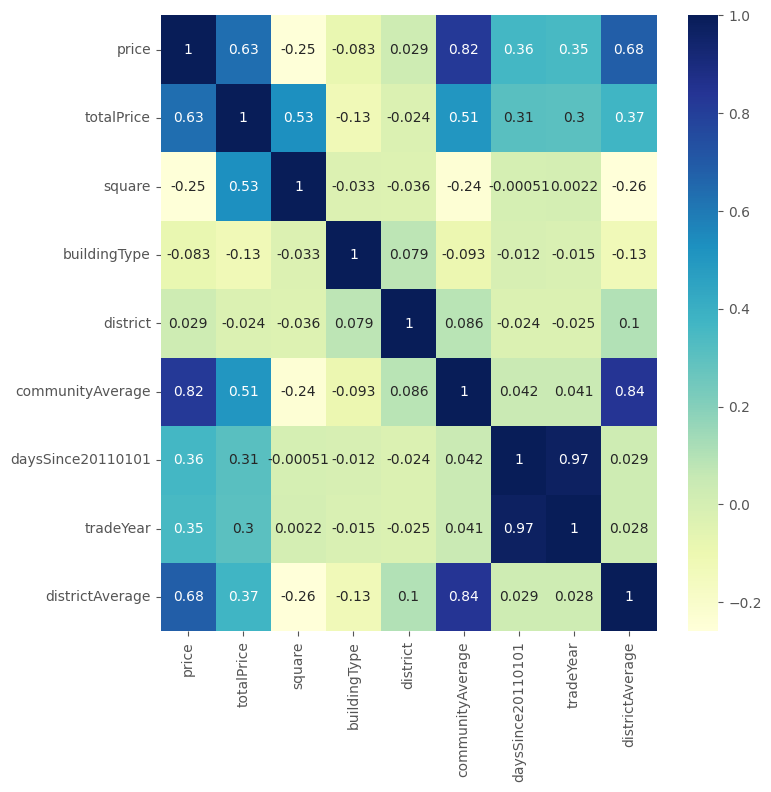

In [38]:
plt.figure(figsize = (8,8))
sns.heatmap(train[['price'] + list(selected_features)].corr(), annot = True, cmap="YlGnBu")
plt.show()

##### XGBoost Model

In [39]:
# Now you can train the XGBoost model on the reduced set of features

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=100)


[0]	validation_0-rmse:37148.32703	validation_1-rmse:59284.47019
[100]	validation_0-rmse:14771.03808	validation_1-rmse:42424.48078
[200]	validation_0-rmse:7034.90746	validation_1-rmse:32429.94079
[300]	validation_0-rmse:4497.07250	validation_1-rmse:26452.98631
[400]	validation_0-rmse:3674.68199	validation_1-rmse:23941.01574
[500]	validation_0-rmse:3301.96983	validation_1-rmse:22510.17661
[600]	validation_0-rmse:3063.62018	validation_1-rmse:21625.37261
[700]	validation_0-rmse:2889.40318	validation_1-rmse:20923.76868
[800]	validation_0-rmse:2748.67245	validation_1-rmse:20371.40337
[900]	validation_0-rmse:2622.95832	validation_1-rmse:19894.91021
[1000]	validation_0-rmse:2508.98180	validation_1-rmse:19336.07280
[1100]	validation_0-rmse:2402.19139	validation_1-rmse:18589.29930
[1200]	validation_0-rmse:2304.22704	validation_1-rmse:17879.02058
[1300]	validation_0-rmse:2214.19840	validation_1-rmse:17317.90255
[1400]	validation_0-rmse:2131.25685	validation_1-rmse:16737.03372
[1500]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Feature Importances

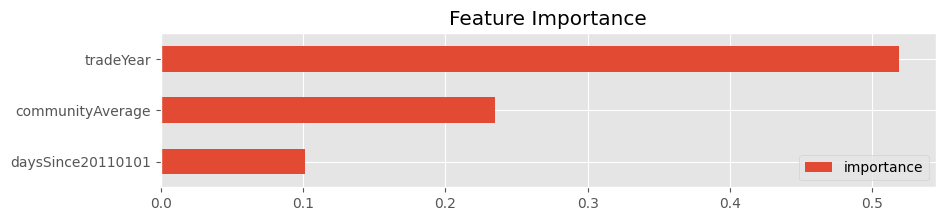

In [40]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values(by='importance',ascending=False).head(3).iloc[::-1].plot(kind='barh', title='Feature Importance', figsize=(10,2))
plt.show()

In [41]:
fi.sort_values(by='importance',ascending=False).head(8)

,importance
tradeYear,0.518570
communityAverage,0.235186
daysSince20110101,0.101687
totalPrice,0.038663
square,0.035426
districtAverage,0.030256
buildingType,0.009803
district,0.005423


In [42]:
df[['tradeYear', 'price']].corr()

,tradeYear,price
tradeYear,1.000000,0.531219
price,0.531219,1.000000


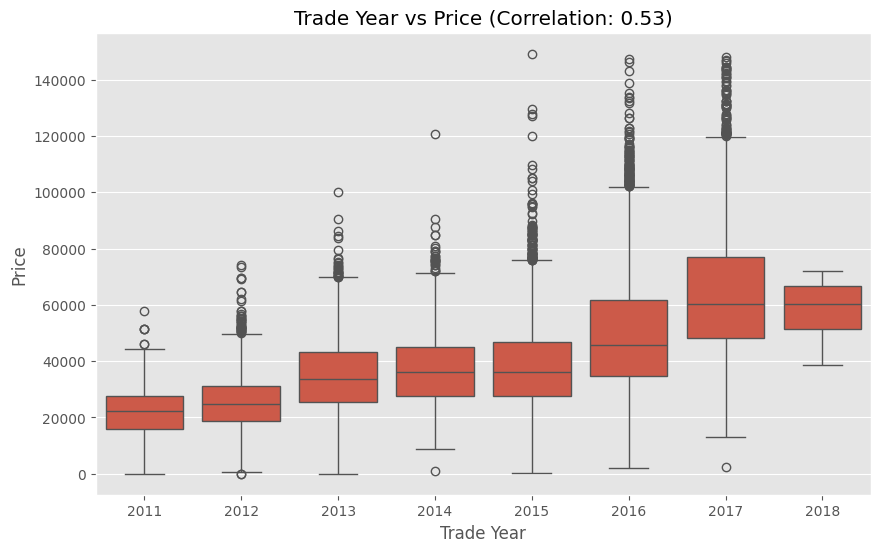

In [43]:
# plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='tradeYear', y='price', data=df)
plt.title('Trade Year vs Price (Correlation: 0.53)')
plt.xlabel('Trade Year')
plt.ylabel('Price')
plt.show()

- The boxplot for "Trade Year vs Price" shows the distribution of prices for each year from 2011 to 2018. 
- The boxes represent the interquartile range (IQR), where the middle line in each box is the median price. 
- The "whiskers" extend to the furthest points that are not considered outliers, and the individual points beyond the whiskers are outliers. 
- The plot suggests that median prices might have increased over the years, and there's a wide range of prices every year, with many outliers indicating very high prices.

In [44]:
df[['communityAverage', 'price']].corr()

,communityAverage,price
communityAverage,1.000000,0.661299
price,0.661299,1.000000


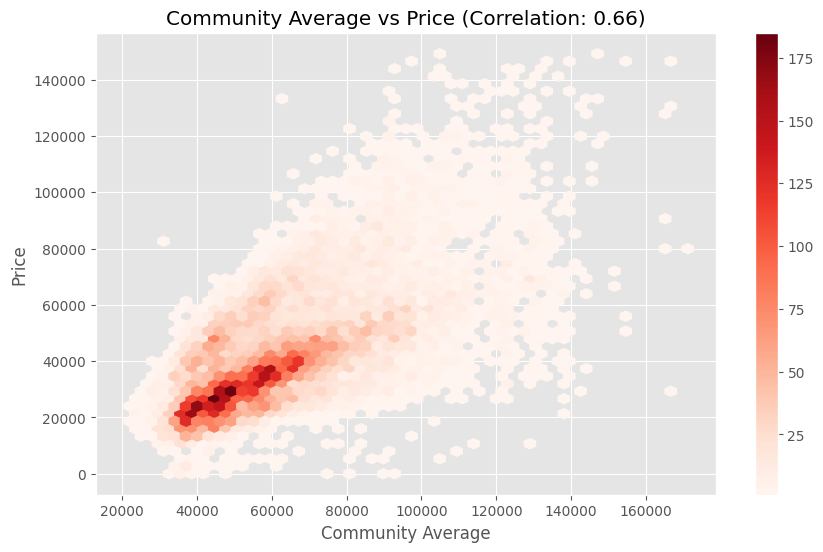

In [45]:
plt.figure(figsize=(10, 6))
plt.hexbin(df['communityAverage'], df['price'], gridsize=50, cmap='Reds', mincnt=1)
plt.colorbar()
plt.title('Community Average vs Price (Correlation: 0.66)')
plt.xlabel('Community Average')
plt.ylabel('Price')
plt.show()

- The hexbin plot for "Community Average vs Price" displays the relationship between the average price in a community and individual property prices. 
- The hexagons are colored based on the number of observations within each bin, with darker colors indicating a higher density of data points. 
- This plot suggests a **positive correlation** between community average prices and individual property prices—higher community averages tend to correspond with higher individual property prices. 
- However, there's a spread which suggests variability within communities, and some properties significantly deviate from the average.

#### (iv) Evaluation

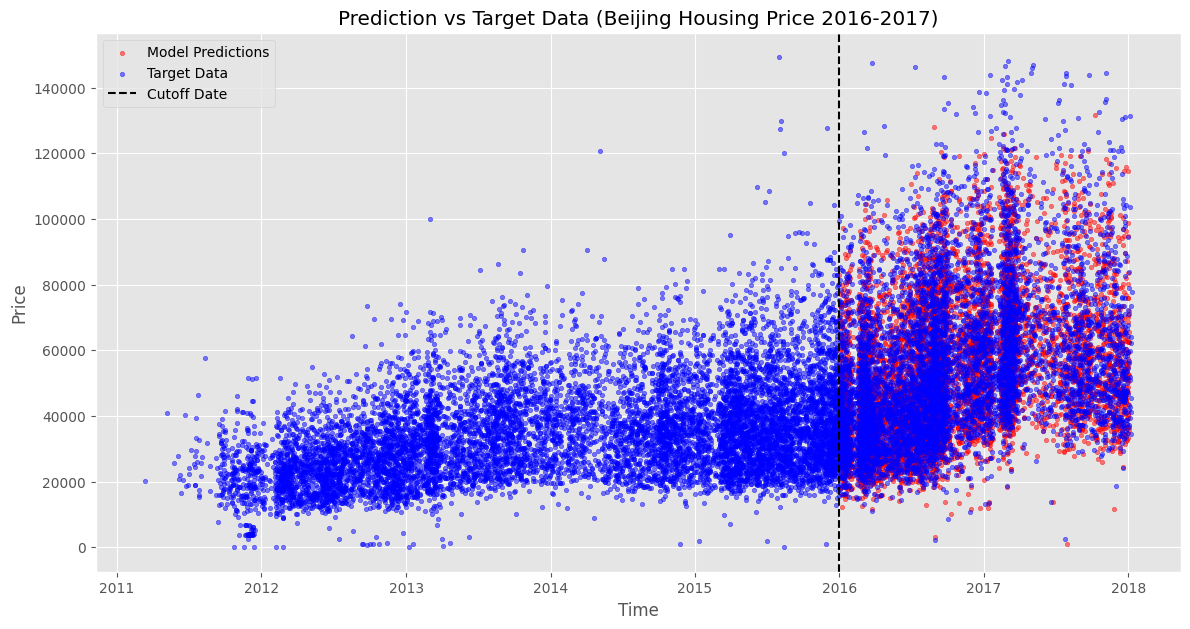

In [46]:
test['prediction'] = xgb_model.predict(X_test)
actual_df = actual_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

def plot_predictions(actual_df):
    plt.figure(figsize=(14, 7))

    # Jitter the 'tradeTime' for actual data
    jitter = pd.to_timedelta(np.random.uniform(-10, 10, size=len(actual_df)), unit='d')
    trade_time_jittered = actual_df['tradeTime'] + jitter

    # Plot predicted data first with lower zorder
    plt.scatter(actual_df['tradeTime'], actual_df['prediction'], label='Model Predictions', color='red', alpha=0.5, s=10, zorder=1)

    # Plot actual data with jitter and higher zorder
    plt.scatter(trade_time_jittered, actual_df['price'], label='Target Data', color='blue', alpha=0.5, s=10, zorder=2)

    # Adding the cutoff date line
    plt.axvline(pd.to_datetime("2016-01-01"), color='black', ls='--', label='Cutoff Date')

    # Improve the axes and labels
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Prediction vs Target Data (Beijing Housing Price 2016-2017)')
    plt.legend()
    plt.show()

# Call the function to plot the predictions
plot_predictions(actual_df)

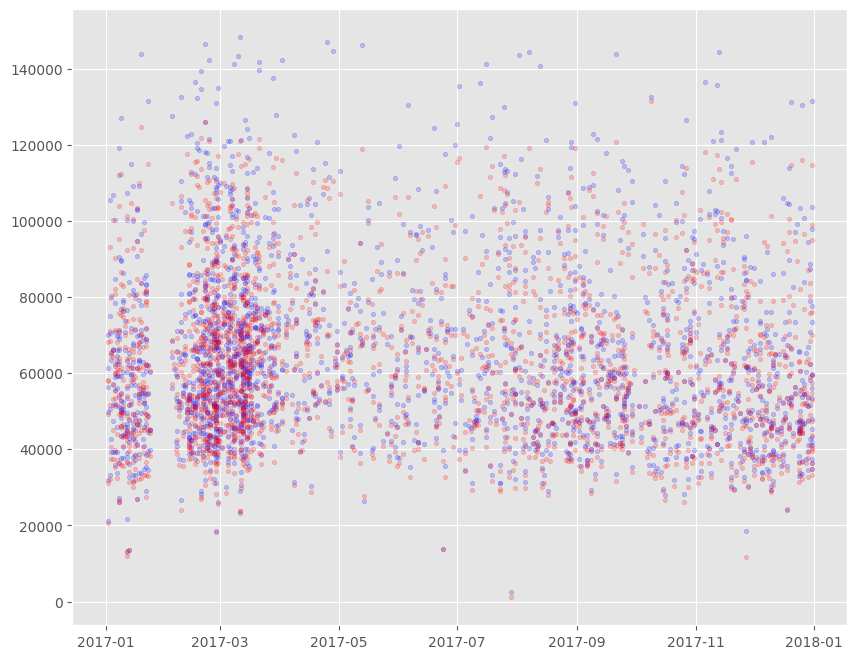

In [47]:
plt.figure(figsize=(10, 8))
week_df = actual_df.loc[(actual_df['tradeTime'] > '2017-01-01') & (actual_df['tradeTime'] < '2018-01-01')] 
plt.scatter(week_df['tradeTime'], week_df['price'], alpha=0.2, s=10, color='blue')
plt.scatter(week_df['tradeTime'], week_df['prediction'], alpha=0.2, s=10, color='red')
plt.show()                     

In [48]:
score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4007.35


Worst predicted values

In [49]:
test['error'] = test[TARGET] - test['prediction']
worst_pred = test.groupby(['daysSince20110101'])[['error', 'district']].mean().sort_values(by=['error','district'], ascending=[False, False])
worst_pred.head(200)['district'].value_counts()

7.000000    14
6.000000    11
8.000000     8
8.500000     7
6.333333     6
            ..
6.307692     1
6.444444     1
6.404762     1
6.642857     1
6.285714     1
Name: district, Length: 108, dtype: int64

Best predicted values

In [50]:
test.groupby(['daysSince20110101'])['error'].mean().sort_values(ascending=True).head(10)

daysSince20110101
543   -2846.562500
549   -2226.179688
552   -2060.031250
529   -1621.500000
672   -1592.138021
499   -1394.197266
627   -1265.871094
401   -1215.023438
638   -1135.558594
539    -964.105469
Name: error, dtype: float64

Measuring Average Error

In [51]:
r2_score = r2_score(test[TARGET], test['prediction'])
r2_score

0.9686299152243021

In [52]:
adjusted_r2 = 1 - (1 - r2_score) * ((len(test[TARGET]) - 1) / (len(test[TARGET]) - 8 - 1))

In [56]:
adjusted_r2

0.9685951849892889

In [53]:
test['AtoP'] = test[TARGET]/test['prediction']
test['AtoP'].mean()

1.0294392897717985


The metric AtoP (Actual to Prediction ratio) is calculated by dividing the actual values by the predicted values. An AtoP value:

- Equal to 1 suggests perfect predictions.
- Greater than 1 indicates underprediction.
- Less than 1 indicates overprediction.

The mean AtoP of approximately 1.029 suggests that on average, the model's predictions are about 2.9% lower than the actual values. This is a fairly close approximation, indicating the model's predictions are quite accurate, with a slight tendency to underestimate the target value.

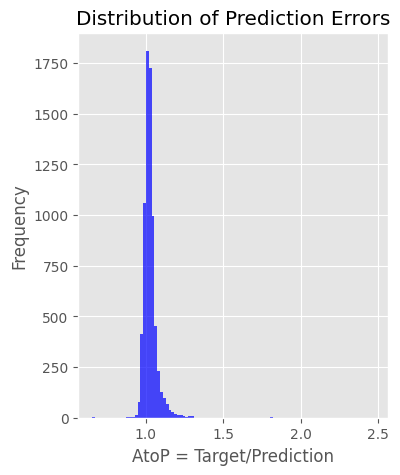

In [54]:
# Plot the histogram - error 
plt.figure(figsize=(4, 5))
max_error = max(test['AtoP'])
min_error = min(test['AtoP'])
plt.hist(test['AtoP'], bins=100, alpha=0.7, color='blue', range=[min(test['AtoP']),max(test['AtoP'])])
# plt.xticks(np.arange(-max_abs_error, max_abs_error + 5000, 5000))
plt.title('Distribution of Prediction Errors')
plt.xlabel('AtoP = Target/Prediction')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

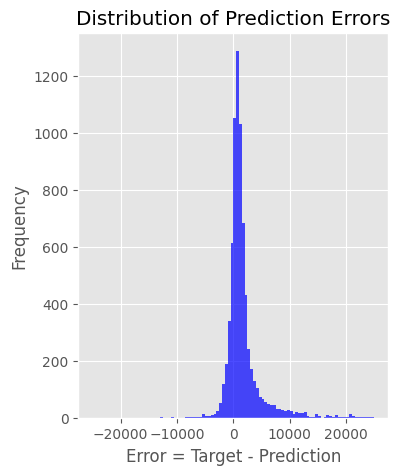

In [55]:
# Plot the histogram - error 
plt.figure(figsize=(4, 5))
max_error = max(test['error'])
min_error = min(test['error'])
plt.hist(test['error'], bins=100, alpha=0.7, color='blue', range=[-25000, 25000])
# plt.xticks(np.arange(-max_abs_error, max_abs_error + 5000, 5000))
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error = Target - Prediction')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Implication: 
- The histogram shows a right-skewed distribution, which typically indicates that the model has a tendency to under-predict the target variable.
- The presence of errors to the left of zero suggests that there are also instances where the model over-predicts the target value.
- The peak at the left edge indicates that for a significant number of predictions, the model is quite accurate, with small errors.

##### Conclusion:

- The data suggests that community-related factors, captured by **communityAverage**, are highly influential in determining house prices, which aligns with the common real estate adage "location, location, location." 
- The importance of **tradeYear** could indicate that market dynamics, such as price trends over time, play a significant role in house valuation.

The real-life implication is that both location-specific factors and temporal market trends should be carefully considered when assessing property values.